# Semi-Lagrangian method

Let us consider an abstract scalar advection equation of the form
$$
\frac{\partial f}{\partial t}+ a(x, t) \cdot \nabla f = 0. 
$$
The characteristic curves associated to this equation are the solutions of the ordinary differential equations
$$
\frac{dX}{dt} = a(X(t), t)
$$
We shall denote by $X(t, x, s)$ the unique solution of this equation associated to the initial condition $X(s) = x$.

The classical semi-Lagrangian method is based on a backtracking of characteristics. Two steps are needed to update the distribution function $f^{n+1}$ at $t^{n+1}$ from its value $f^n$ at time $t^n$ :
1. For each grid point $x_i$ compute $X(t^n; x_i, t^{n+1})$ the value of the characteristic at $t^n$ which takes the value $x_i$ at $t^{n+1}$.
2. As the distribution solution of first equation verifies 
$$f^{n+1}(x_i) = f^n(X(t^n; x_i, t^{n+1})),$$
we obtain the desired value of $f^{n+1}(x_i)$ by computing $f^n(X(t^n;x_i,t^{n+1})$ by interpolation as $X(t^n; x_i, t^{n+1})$ is in general not a grid point.

*[Eric Sonnendrücker - Numerical methods for the Vlasov equations](http://www-m16.ma.tum.de/foswiki/pub/M16/Allgemeines/NumMethVlasov/Num-Meth-Vlasov-Notes.pdf)*

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [2]:
# Disable the pager for lprun
from IPython.core import page
page.page = print

## Bspline interpolator

- [De Boor's Algorithm - Wikipedia](https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)

### Numpy

In [3]:
import numpy as np
from scipy.fftpack import fft, ifft 

def bspline_python(p, j, x):
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        assert (x >= 0.0) & (x <= 1.0)
        assert (type(p) == int) & (type(j) == int)
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x - j) / p
            w1 = (x - j - 1) / p
        return w * bspline_python(p - 1, j, x) + (1 - w1) * bspline_python(p - 1, j + 1, x)

class BSplineNumpy:
    
    """ Class to compute BSL advection of 1d function """
    
    def __init__(self, p, xmin, xmax, ncells):
        assert p & 1 == 1  # check that p is odd
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline_python(p, -(p + 1) // 2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline_python(p, j - (p + 1) // 2, 0.0) * 2 * np.cos(j * self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
    
    def interpolate_disp(self, f, alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        p = self.p
        assert (np.size(f) == self.ncells)
        # compute eigenvalues of cubic splines evaluated at displaced points
        ishift = np.floor(-alpha / self.deltax)
        beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0.)
        for j in range(-(p-1)//2, (p+1)//2 + 1):
            self.eigalpha += bspline_python(p, j-(p+1)//2, beta) * np.exp((ishift+j)*1j*self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(ifft(fft(f) * self.eigalpha / self.eig_bspl))



### Interpolation test
$\sin$ function after a displacement of alpha

In [4]:
def interpolation_test(BSplineClass):
    """ Test to check interpolation"""
    n = 64
    cs = BSplineClass(3,0,1,n)
    x = np.linspace(0,1,n, endpoint=False)
    f = np.sin(x*4*np.pi)
    alpha = 0.2
    return np.allclose(np.sin((x-alpha)*4*np.pi), cs.interpolate_disp(f, alpha))
    

interpolation_test(BSplineNumpy)

True

### Profiling the code

In [5]:
%load_ext line_profiler

In [6]:
n =1024
cs = BSplineNumpy(3,0,1,n)
x = np.linspace(0,1,n, endpoint=False)
f = np.sin(x*4*np.pi)
alpha = 0.2;
%lprun -s -f cs.interpolate_disp -T lp_results.txt cs.interpolate_disp(f, alpha);

Timer unit: 1e-06 s

Total time: 0.000922 s
File: <ipython-input-3-e4558e235572>
Function: interpolate_disp at line 38

Line #      Hits         Time  Per Hit   % Time  Line Contents
    38                                               def interpolate_disp(self, f, alpha):
    39                                                   """compute the interpolating spline of degree p of odd degree 
    40                                                   of a function f on a periodic uniform mesh, at
    41                                                   all points xi-alpha"""
    42         1          2.0      2.0      0.2          p = self.p
    43         1         10.0     10.0      1.1          assert (np.size(f) == self.ncells)
    44                                                   # compute eigenvalues of cubic splines evaluated at displaced points
    45         1          8.0      8.0      0.9          ishift = np.floor(-alpha / self.deltax)
    46         1          2.0      2.0 

### Fortran

Replace the bspline computation by a fortran function, call it **bspline_fortran**.

In [7]:
%load_ext fortranmagic

In [8]:
%%fortran
recursive function bspline_fortran(p, j, x) result(res)
    integer :: p, j
    real(8) :: x, w, w1
    real(8) :: res

    if (p == 0) then
        if (j == 0) then
            res = 1.0
            return
        else
            res = 0.0
            return
        end if
    else
        w = (x - j) / p
        w1 = (x - j - 1) / p
    end if
    
    res = w * bspline_fortran(p-1,j,x) &
    +(1-w1)*bspline_fortran(p-1,j+1,x)

end function bspline_fortran

In [9]:
import numpy as np
from scipy.fftpack import fft, ifft

class BSplineFortran:
    
    def __init__(self, p, xmin, xmax, ncells):
        assert p & 1 == 1  # check that p is odd
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline_fortran(p, -(p+1)//2, 0.0)
        for j in range(1, (p+1)//2):
            self.eig_bspl += bspline_fortran(p, j-(p+1)//2,0.0)*2*np.cos(j*self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
    
    def interpolate_disp(self, f, alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        p = self.p
        assert (np.size(f) == self.ncells)
        # compute eigenvalues of cubic splines evaluated at displaced points
        ishift = np.floor(-alpha / self.deltax)
        beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0.)
        for j in range(-(p-1)//2, (p+1)//2 + 1):
            self.eigalpha += bspline_fortran(p, j-(p+1)//2, beta) * np.exp((ishift+j)*1j*self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(ifft(fft(f) * self.eigalpha / self.eig_bspl))



In [10]:
interpolation_test(BSplineFortran)

True

### Numba

Create a optimized function of bspline python function with Numba. Call it bspline_numba.

In [11]:
# %load solutions/landau_damping/bspline_numba.py
from numba import jit,  int32, float64
from scipy.fftpack import fft, ifft

@jit("float64(int32,int32,float64)",nopython=True)
def bspline_numba(p, j, x):
    
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        
        assert ((x >= 0.0) & (x <= 1.0))
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x-j)/p
            w1 = (x-j-1)/p
        return w * bspline_numba(p-1,j,x)+(1-w1)*bspline_numba(p-1,j+1,x)

In [12]:
class BSplineNumba:
    
    def __init__(self, p, xmin, xmax, ncells):
        assert p & 1 == 1  # check that p is odd
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline_numba(p, -(p+1)//2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline_numba(p,j-(p+1)//2,0.0)*2*np.cos(j*self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
        
    def interpolate_disp(self, f, alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        
        p = self.p
        assert (np.size(f) == self.ncells)
        # compute eigenvalues of cubic splines evaluated at displaced points
        ishift = np.floor(-alpha / self.deltax)
        beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0.)
        for j in range(-(p-1)//2, (p+1)//2+1):
            self.eigalpha += bspline_numba(p, j-(p+1)//2, beta)*np.exp((ishift+j)*1j*self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(ifft(fft(f) * self.eigalpha / self.eig_bspl))



In [13]:
interpolation_test(BSplineNumba)

True

### Pythran

In [14]:
import pythran

In [15]:
%load_ext pythran.magic

In [16]:
# %load solutions/landau_damping/bspline_pythran.py

#pythran export bspline_pythran(int,int,float64)
def bspline_pythran(p, j, x):
    if p == 0:
        if j == 0:
            return 1.0
        else:
            return 0.0
    else:
        w = (x-j)/p
        w1 = (x-j-1)/p
    return w * bspline_pythran(p-1,j,x)+(1-w1)*bspline_pythran(p-1,j+1,x)

In [17]:
class BSplinePythran:
    
    def __init__(self, p, xmin, xmax, ncells):
        assert p & 1 == 1  # check that p is odd
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline_pythran(p, -(p+1)//2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline_pythran(p,j-(p+1)//2,0.0)*2*np.cos(j*self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
        
    def interpolate_disp(self, f, alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        
        p = self.p
        assert (f.size == self.ncells)
        # compute eigenvalues of cubic splines evaluated at displaced points
        ishift = np.floor(-alpha / self.deltax)
        beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0.)
        for j in range(-(p-1)//2, (p+1)//2+1):
            self.eigalpha += bspline_pythran(p, j-(p+1)//2, beta)*np.exp((ishift+j)*1j*self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(ifft(fft(f) * self.eigalpha / self.eig_bspl))



In [18]:
interpolation_test(BSplinePythran)

True

### Cython

- Create **bspline_cython** function.

In [19]:
%load_ext cython

In [20]:
%%cython -a
def bspline_cython(p, j, x):
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        assert (x >= 0.0) & (x <= 1.0)
        assert (type(p) == int) & (type(j) == int)
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x - j) / p
            w1 = (x - j - 1) / p
        return w * bspline_cython(p - 1, j, x) + (1 - w1) * bspline_cython(p - 1, j + 1, x)



In [21]:
%%cython
import cython
import numpy as np
cimport numpy as np
from scipy.fftpack import fft, ifft

@cython.cdivision(True)
cdef double bspline_cython(int p, int j, double x):
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        cdef double w, w1
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x - j) / p
            w1 = (x - j - 1) / p
        return w * bspline_cython(p-1,j,x)+(1-w1)*bspline_cython(p-1,j+1,x)

class BSplineCython:
    
    def __init__(self, p, xmin, xmax, ncells):
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline_cython(p,-(p+1)//2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline_cython(p,j-(p+1)//2,0.0)*2*np.cos(j*self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def interpolate_disp(self,  f,  alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        cdef Py_ssize_t j
        cdef int p = self.p
        # compute eigenvalues of cubic splines evaluated at displaced points
        cdef int ishift = np.floor(-alpha / self.deltax)
        cdef double beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0)
        for j in range(-(p-1)//2, (p+1)//2+1):
            self.eigalpha += bspline_cython(p,j-(p+1)//2,beta)*np.exp((ishift+j)*1j*self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(ifft(fft(f) * self.eigalpha / self.eig_bspl))



In [22]:
interpolation_test(BSplineCython)

True

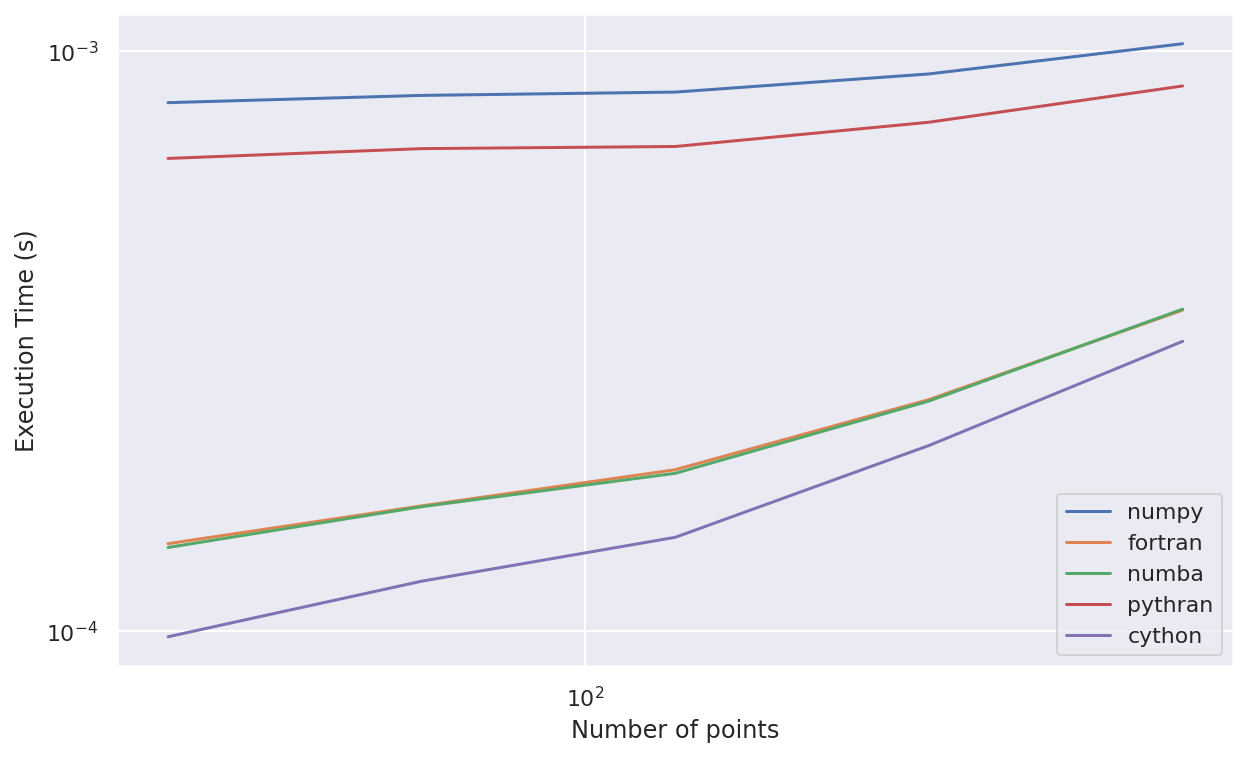

In [23]:
import seaborn; seaborn.set()
from tqdm.notebook import tqdm
Mrange = (2 ** np.arange(5, 10)).astype(int)

t_numpy = []
t_fortran = []
t_numba = []
t_pythran = []
t_cython = []

for M in tqdm(Mrange):
    x = np.linspace(0,1,M, endpoint=False)
    f = np.sin(x*4*np.pi)
    cs1 = BSplineNumpy(5,0,1,M)
    cs2 = BSplineFortran(5,0,1,M)
    cs3 = BSplineNumba(5,0,1,M)
    cs4 = BSplinePythran(5,0,1,M)
    cs5 = BSplineCython(5,0,1,M)
    
    alpha = 0.1
    t1 = %timeit -oq cs1.interpolate_disp(f, alpha)
    t2 = %timeit -oq cs2.interpolate_disp(f, alpha)
    t3 = %timeit -oq cs3.interpolate_disp(f, alpha)
    t4 = %timeit -oq cs4.interpolate_disp(f, alpha)
    t5 = %timeit -oq cs5.interpolate_disp(f, alpha)
    
    t_numpy.append(t1.best)
    t_fortran.append(t2.best)
    t_numba.append(t3.best)
    t_pythran.append(t4.best)
    t_cython.append(t5.best)

plt.loglog(Mrange, t_numpy, label='numpy')
plt.loglog(Mrange, t_fortran, label='fortran')
plt.loglog(Mrange, t_numba, label='numba')
plt.loglog(Mrange, t_pythran, label='pythran')
plt.loglog(Mrange, t_cython, label='cython')
plt.legend(loc='lower right')
plt.xlabel('Number of points')
plt.ylabel('Execution Time (s)');

## Vlasov-Poisson equation
We consider the dimensionless Vlasov-Poisson equation for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$

- [Vlasov Equation - Wikipedia](https://en.wikipedia.org/wiki/Vlasov_equation)

In [24]:
import progressbar

BSpline = dict(numpy=BSplineNumpy,
               fortran=BSplineFortran,
               cython=BSplineCython,
               numba=BSplineNumba,
               pythran=BSplinePythran)

class VlasovPoisson:
    
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv, opt='numpy'):
        
        # Grid
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, endpoint=False, retstep=True)
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, endpoint=False, retstep=True)
        
        # Distribution function
        self.f = np.zeros((nx,nv)) 
        
        # Interpolators for advection
        BSplineClass = BSpline[opt]
        self.cs_x = BSplineClass(3, xmin, xmax, nx)
        self.cs_v = BSplineClass(3, vmin, vmax, nv)
        
        # Modes for Poisson equation
        self.modes = np.zeros(nx)
        k =  2* np.pi / (xmax - xmin)
        self.modes[:nx//2] = k * np.arange(nx//2)
        self.modes[nx//2:] = - k * np.arange(nx//2,0,-1)
        self.modes += self.modes == 0 # avoid division by zero 
        
    def advection_x(self, dt):
        for j in range(self.nv):
            alpha = dt * self.v[j]
            self.f[j,:] = self.cs_x.interpolate_disp(self.f[j,:], alpha)
            
    def advection_v(self, e, dt):
        for i in range(self.nx):
            alpha = dt * e[i] 
            self.f[:,i] = self.cs_v.interpolate_disp(self.f[:,i], alpha)
            
    def compute_rho(self):
        rho = self.dv * np.sum(self.f, axis=0)
        return  rho - rho.mean()
            
    def compute_e(self, rho):
        # compute Ex using that ik*Ex = rho
        rhok = fft(rho)/self.modes
        return np.real(ifft(-1j*rhok))
    
    def run(self, f, nstep, dt):
        self.f = f
        nrj = []
        bar = progressbar.ProgressBar()
        self.advection_x(0.5*dt)
        for istep in bar(range(nstep)):
            rho = self.compute_rho()
            e = self.compute_e(rho)
            self.advection_v(e, dt)
            self.advection_x(dt)
            nrj.append( 0.5*np.log(np.sum(e*e)*self.dx))
                
        return nrj

## Landau Damping

[Landau damping - Wikipedia](https://en.wikipedia.org/wiki/Landau_damping)

N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

  0% (5 of 600) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12

  1% (8 of 600) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12

  2% (13 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:12

  2% (16 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:12

  3% (21 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:12

  4% (26 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:12

  5% (31 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:12

  6% (36 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:12

  6% (41 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:12

  7% (46 of 600) |#                      | Elapsed Time: 0:00:01 ETA:   0:00:12

  8% (51 of 600) |#                      | Elapsed Time: 0:00:01 ETA:   0:00:12

  9% (54 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:12

  9% (58 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:12

 10% (61 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:12

 11% (66 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:12

 11% (69 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:12

 12% (74 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:11

 12% (76 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:11

 13% (81 of 600) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:11

 14% (84 of 600) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:11

 14% (89 of 600) |###                    | Elapsed Time: 0:00:02 ETA:   0:00:11

 15% (92 of 600) |###                    | Elapsed Time: 0:00:02 ETA:   0:00:11

 16% (96 of 600) |###                    | Elapsed Time: 0:00:02 ETA:   0:00:11

 16% (99 of 600) |###                    | Elapsed Time: 0:00:02 ETA:   0:00:11

 17% (104 of 600) |###                   | Elapsed Time: 0:00:02 ETA:   0:00:11

 17% (107 of 600) |###                   | Elapsed Time: 0:00:02 ETA:   0:00:11

 18% (112 of 600) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:11

 19% (117 of 600) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:11

 20% (122 of 600) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:11

 21% (127 of 600) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:10

 21% (130 of 600) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:10

 22% (134 of 600) |####                  | Elapsed Time: 0:00:03 ETA:   0:00:10

 22% (137 of 600) |#####                 | Elapsed Time: 0:00:03 ETA:   0:00:10

 23% (142 of 600) |#####                 | Elapsed Time: 0:00:03 ETA:   0:00:10

 24% (145 of 600) |#####                 | Elapsed Time: 0:00:03 ETA:   0:00:10

 25% (150 of 600) |#####                 | Elapsed Time: 0:00:03 ETA:   0:00:10

 25% (155 of 600) |#####                 | Elapsed Time: 0:00:03 ETA:   0:00:10

 26% (160 of 600) |#####                 | Elapsed Time: 0:00:03 ETA:   0:00:10

 27% (164 of 600) |######                | Elapsed Time: 0:00:03 ETA:   0:00:10

 28% (168 of 600) |######                | Elapsed Time: 0:00:03 ETA:   0:00:10

 28% (173 of 600) |######                | Elapsed Time: 0:00:03 ETA:   0:00:09

 29% (178 of 600) |######                | Elapsed Time: 0:00:04 ETA:   0:00:09

 30% (183 of 600) |######                | Elapsed Time: 0:00:04 ETA:   0:00:09

 31% (188 of 600) |######                | Elapsed Time: 0:00:04 ETA:   0:00:09

 32% (193 of 600) |#######               | Elapsed Time: 0:00:04 ETA:   0:00:09

 33% (198 of 600) |#######               | Elapsed Time: 0:00:04 ETA:   0:00:09

 33% (203 of 600) |#######               | Elapsed Time: 0:00:04 ETA:   0:00:08

 34% (206 of 600) |#######               | Elapsed Time: 0:00:04 ETA:   0:00:08

 35% (210 of 600) |#######               | Elapsed Time: 0:00:04 ETA:   0:00:08

 35% (213 of 600) |#######               | Elapsed Time: 0:00:04 ETA:   0:00:08

 36% (218 of 600) |#######               | Elapsed Time: 0:00:04 ETA:   0:00:08

 36% (221 of 600) |########              | Elapsed Time: 0:00:05 ETA:   0:00:08

 37% (226 of 600) |########              | Elapsed Time: 0:00:05 ETA:   0:00:08

 38% (231 of 600) |########              | Elapsed Time: 0:00:05 ETA:   0:00:08

 39% (236 of 600) |########              | Elapsed Time: 0:00:05 ETA:   0:00:08

 40% (241 of 600) |########              | Elapsed Time: 0:00:05 ETA:   0:00:07

 40% (244 of 600) |########              | Elapsed Time: 0:00:05 ETA:   0:00:07

 41% (248 of 600) |#########             | Elapsed Time: 0:00:05 ETA:   0:00:07

 41% (251 of 600) |#########             | Elapsed Time: 0:00:05 ETA:   0:00:07

 42% (256 of 600) |#########             | Elapsed Time: 0:00:05 ETA:   0:00:07

 43% (259 of 600) |#########             | Elapsed Time: 0:00:05 ETA:   0:00:07

 44% (264 of 600) |#########             | Elapsed Time: 0:00:05 ETA:   0:00:07

 44% (269 of 600) |#########             | Elapsed Time: 0:00:06 ETA:   0:00:07

 45% (274 of 600) |##########            | Elapsed Time: 0:00:06 ETA:   0:00:07

 46% (279 of 600) |##########            | Elapsed Time: 0:00:06 ETA:   0:00:07

 47% (282 of 600) |##########            | Elapsed Time: 0:00:06 ETA:   0:00:07

 47% (287 of 600) |##########            | Elapsed Time: 0:00:06 ETA:   0:00:06

 48% (292 of 600) |##########            | Elapsed Time: 0:00:06 ETA:   0:00:06

 49% (297 of 600) |##########            | Elapsed Time: 0:00:06 ETA:   0:00:06

 50% (302 of 600) |###########           | Elapsed Time: 0:00:06 ETA:   0:00:06

 51% (307 of 600) |###########           | Elapsed Time: 0:00:06 ETA:   0:00:06

 52% (312 of 600) |###########           | Elapsed Time: 0:00:07 ETA:   0:00:06

 52% (317 of 600) |###########           | Elapsed Time: 0:00:07 ETA:   0:00:06

 53% (322 of 600) |###########           | Elapsed Time: 0:00:07 ETA:   0:00:06

 54% (327 of 600) |###########           | Elapsed Time: 0:00:07 ETA:   0:00:05

 55% (332 of 600) |############          | Elapsed Time: 0:00:07 ETA:   0:00:05

 55% (335 of 600) |############          | Elapsed Time: 0:00:07 ETA:   0:00:05

 56% (340 of 600) |############          | Elapsed Time: 0:00:07 ETA:   0:00:05

 57% (345 of 600) |############          | Elapsed Time: 0:00:07 ETA:   0:00:05

 58% (350 of 600) |############          | Elapsed Time: 0:00:07 ETA:   0:00:05

 59% (355 of 600) |#############         | Elapsed Time: 0:00:07 ETA:   0:00:05

 60% (360 of 600) |#############         | Elapsed Time: 0:00:08 ETA:   0:00:05

 60% (365 of 600) |#############         | Elapsed Time: 0:00:08 ETA:   0:00:05

 61% (370 of 600) |#############         | Elapsed Time: 0:00:08 ETA:   0:00:04

 62% (373 of 600) |#############         | Elapsed Time: 0:00:08 ETA:   0:00:04

 63% (378 of 600) |#############         | Elapsed Time: 0:00:08 ETA:   0:00:04

 63% (383 of 600) |##############        | Elapsed Time: 0:00:08 ETA:   0:00:04

 64% (388 of 600) |##############        | Elapsed Time: 0:00:08 ETA:   0:00:04

 65% (393 of 600) |##############        | Elapsed Time: 0:00:08 ETA:   0:00:04

 66% (398 of 600) |##############        | Elapsed Time: 0:00:08 ETA:   0:00:04

 67% (403 of 600) |##############        | Elapsed Time: 0:00:09 ETA:   0:00:04

 68% (408 of 600) |##############        | Elapsed Time: 0:00:09 ETA:   0:00:04

 68% (411 of 600) |###############       | Elapsed Time: 0:00:09 ETA:   0:00:04

 69% (416 of 600) |###############       | Elapsed Time: 0:00:09 ETA:   0:00:04

 70% (421 of 600) |###############       | Elapsed Time: 0:00:09 ETA:   0:00:03

 71% (426 of 600) |###############       | Elapsed Time: 0:00:09 ETA:   0:00:03

 71% (431 of 600) |###############       | Elapsed Time: 0:00:09 ETA:   0:00:03

 72% (436 of 600) |###############       | Elapsed Time: 0:00:09 ETA:   0:00:03

 73% (441 of 600) |################      | Elapsed Time: 0:00:09 ETA:   0:00:03

 74% (445 of 600) |################      | Elapsed Time: 0:00:09 ETA:   0:00:03

 74% (449 of 600) |################      | Elapsed Time: 0:00:10 ETA:   0:00:03

 75% (454 of 600) |################      | Elapsed Time: 0:00:10 ETA:   0:00:03

 76% (459 of 600) |################      | Elapsed Time: 0:00:10 ETA:   0:00:03

 77% (464 of 600) |#################     | Elapsed Time: 0:00:10 ETA:   0:00:03

 78% (469 of 600) |#################     | Elapsed Time: 0:00:10 ETA:   0:00:02

 79% (474 of 600) |#################     | Elapsed Time: 0:00:10 ETA:   0:00:02

 79% (479 of 600) |#################     | Elapsed Time: 0:00:10 ETA:   0:00:02

 80% (484 of 600) |#################     | Elapsed Time: 0:00:10 ETA:   0:00:02

 81% (487 of 600) |#################     | Elapsed Time: 0:00:10 ETA:   0:00:02

 82% (492 of 600) |##################    | Elapsed Time: 0:00:10 ETA:   0:00:02

 82% (497 of 600) |##################    | Elapsed Time: 0:00:11 ETA:   0:00:02

 83% (502 of 600) |##################    | Elapsed Time: 0:00:11 ETA:   0:00:02

 84% (507 of 600) |##################    | Elapsed Time: 0:00:11 ETA:   0:00:02

 84% (509 of 600) |##################    | Elapsed Time: 0:00:11 ETA:   0:00:01

 85% (514 of 600) |##################    | Elapsed Time: 0:00:11 ETA:   0:00:01

 86% (517 of 600) |##################    | Elapsed Time: 0:00:11 ETA:   0:00:01

 87% (522 of 600) |###################   | Elapsed Time: 0:00:11 ETA:   0:00:01

 87% (525 of 600) |###################   | Elapsed Time: 0:00:11 ETA:   0:00:01

 88% (530 of 600) |###################   | Elapsed Time: 0:00:11 ETA:   0:00:01

 88% (532 of 600) |###################   | Elapsed Time: 0:00:11 ETA:   0:00:01

 89% (537 of 600) |###################   | Elapsed Time: 0:00:11 ETA:   0:00:01

 90% (540 of 600) |###################   | Elapsed Time: 0:00:12 ETA:   0:00:01

 90% (545 of 600) |###################   | Elapsed Time: 0:00:12 ETA:   0:00:01

 91% (547 of 600) |####################  | Elapsed Time: 0:00:12 ETA:   0:00:01

 92% (552 of 600) |####################  | Elapsed Time: 0:00:12 ETA:   0:00:01

 92% (555 of 600) |####################  | Elapsed Time: 0:00:12 ETA:   0:00:01

 93% (560 of 600) |####################  | Elapsed Time: 0:00:12 ETA:   0:00:00

 93% (563 of 600) |####################  | Elapsed Time: 0:00:12 ETA:   0:00:00

 94% (568 of 600) |####################  | Elapsed Time: 0:00:12 ETA:   0:00:00

 95% (570 of 600) |####################  | Elapsed Time: 0:00:12 ETA:   0:00:00

 95% (574 of 600) |##################### | Elapsed Time: 0:00:12 ETA:   0:00:00

 96% (578 of 600) |##################### | Elapsed Time: 0:00:12 ETA:   0:00:00

 97% (583 of 600) |##################### | Elapsed Time: 0:00:13 ETA:   0:00:00

 98% (588 of 600) |##################### | Elapsed Time: 0:00:13 ETA:   0:00:00

 98% (593 of 600) |##################### | Elapsed Time: 0:00:13 ETA:   0:00:00

 99% (597 of 600) |##################### | Elapsed Time: 0:00:13 ETA:   0:00:00

100% (600 of 600) |######################| Elapsed Time: 0:00:13 Time:  0:00:13

N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

  1% (8 of 600) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

  2% (16 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:06

 numpy        : 13.4400 


  3% (23 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:06

  5% (31 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:07

  6% (38 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:07

  7% (46 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:06

  9% (54 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06

 10% (61 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06

 11% (69 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06

 12% (76 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06

 14% (84 of 600) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:06

 15% (92 of 600) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:06

 16% (99 of 600) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:05

 17% (107 of 600) |###                   | Elapsed Time: 0:00:01 ETA:   0:00:05

 19% (114 of 600) |####                  | Elapsed Time: 0:00:01 ETA:   0:00:05

 20% (122 of 600) |####                  | Elapsed Time: 0:00:01 ETA:   0:00:05

 21% (130 of 600) |####                  | Elapsed Time: 0:00:01 ETA:   0:00:05

 22% (137 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:05

 24% (145 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:05

 25% (152 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:05

 26% (160 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:05

 28% (168 of 600) |######                | Elapsed Time: 0:00:01 ETA:   0:00:04

 29% (175 of 600) |######                | Elapsed Time: 0:00:02 ETA:   0:00:04

 30% (183 of 600) |######                | Elapsed Time: 0:00:02 ETA:   0:00:04

 31% (190 of 600) |######                | Elapsed Time: 0:00:02 ETA:   0:00:04

 33% (198 of 600) |#######               | Elapsed Time: 0:00:02 ETA:   0:00:04

 34% (206 of 600) |#######               | Elapsed Time: 0:00:02 ETA:   0:00:04

 35% (213 of 600) |#######               | Elapsed Time: 0:00:02 ETA:   0:00:04

 36% (221 of 600) |########              | Elapsed Time: 0:00:02 ETA:   0:00:04

 38% (228 of 600) |########              | Elapsed Time: 0:00:02 ETA:   0:00:04

 39% (236 of 600) |########              | Elapsed Time: 0:00:02 ETA:   0:00:04

 40% (244 of 600) |########              | Elapsed Time: 0:00:02 ETA:   0:00:04

 41% (251 of 600) |#########             | Elapsed Time: 0:00:02 ETA:   0:00:03

 43% (259 of 600) |#########             | Elapsed Time: 0:00:03 ETA:   0:00:03

 44% (266 of 600) |#########             | Elapsed Time: 0:00:03 ETA:   0:00:03

 45% (274 of 600) |##########            | Elapsed Time: 0:00:03 ETA:   0:00:03

 47% (282 of 600) |##########            | Elapsed Time: 0:00:03 ETA:   0:00:03

 48% (289 of 600) |##########            | Elapsed Time: 0:00:03 ETA:   0:00:03

 49% (297 of 600) |##########            | Elapsed Time: 0:00:03 ETA:   0:00:03

 50% (304 of 600) |###########           | Elapsed Time: 0:00:03 ETA:   0:00:03

 52% (312 of 600) |###########           | Elapsed Time: 0:00:03 ETA:   0:00:03

 53% (319 of 600) |###########           | Elapsed Time: 0:00:03 ETA:   0:00:03

 54% (327 of 600) |###########           | Elapsed Time: 0:00:03 ETA:   0:00:03

 55% (335 of 600) |############          | Elapsed Time: 0:00:03 ETA:   0:00:03

 57% (342 of 600) |############          | Elapsed Time: 0:00:03 ETA:   0:00:03

 58% (350 of 600) |############          | Elapsed Time: 0:00:04 ETA:   0:00:02

 59% (357 of 600) |#############         | Elapsed Time: 0:00:04 ETA:   0:00:02

 60% (365 of 600) |#############         | Elapsed Time: 0:00:04 ETA:   0:00:02

 62% (373 of 600) |#############         | Elapsed Time: 0:00:04 ETA:   0:00:02

 63% (380 of 600) |#############         | Elapsed Time: 0:00:04 ETA:   0:00:02

 64% (388 of 600) |##############        | Elapsed Time: 0:00:04 ETA:   0:00:02

 65% (395 of 600) |##############        | Elapsed Time: 0:00:04 ETA:   0:00:02

 67% (403 of 600) |##############        | Elapsed Time: 0:00:04 ETA:   0:00:02

 68% (411 of 600) |###############       | Elapsed Time: 0:00:04 ETA:   0:00:02

 69% (418 of 600) |###############       | Elapsed Time: 0:00:04 ETA:   0:00:02

 71% (426 of 600) |###############       | Elapsed Time: 0:00:04 ETA:   0:00:02

 72% (433 of 600) |###############       | Elapsed Time: 0:00:05 ETA:   0:00:01

 73% (441 of 600) |################      | Elapsed Time: 0:00:05 ETA:   0:00:01

 74% (449 of 600) |################      | Elapsed Time: 0:00:05 ETA:   0:00:01

 76% (456 of 600) |################      | Elapsed Time: 0:00:05 ETA:   0:00:01

 77% (464 of 600) |#################     | Elapsed Time: 0:00:05 ETA:   0:00:01

 78% (471 of 600) |#################     | Elapsed Time: 0:00:05 ETA:   0:00:01

 79% (479 of 600) |#################     | Elapsed Time: 0:00:05 ETA:   0:00:01

 81% (487 of 600) |#################     | Elapsed Time: 0:00:05 ETA:   0:00:01

 82% (494 of 600) |##################    | Elapsed Time: 0:00:05 ETA:   0:00:01

 83% (502 of 600) |##################    | Elapsed Time: 0:00:05 ETA:   0:00:01

 84% (509 of 600) |##################    | Elapsed Time: 0:00:05 ETA:   0:00:01

 86% (517 of 600) |##################    | Elapsed Time: 0:00:06 ETA:   0:00:00

 87% (525 of 600) |###################   | Elapsed Time: 0:00:06 ETA:   0:00:00

 88% (532 of 600) |###################   | Elapsed Time: 0:00:06 ETA:   0:00:00

 90% (540 of 600) |###################   | Elapsed Time: 0:00:06 ETA:   0:00:00

 91% (547 of 600) |####################  | Elapsed Time: 0:00:06 ETA:   0:00:00

 92% (555 of 600) |####################  | Elapsed Time: 0:00:06 ETA:   0:00:00

 93% (563 of 600) |####################  | Elapsed Time: 0:00:06 ETA:   0:00:00

 95% (570 of 600) |####################  | Elapsed Time: 0:00:06 ETA:   0:00:00

 96% (578 of 600) |##################### | Elapsed Time: 0:00:06 ETA:   0:00:00

 97% (585 of 600) |##################### | Elapsed Time: 0:00:06 ETA:   0:00:00

 98% (593 of 600) |##################### | Elapsed Time: 0:00:06 ETA:   0:00:00

100% (600 of 600) |######################| Elapsed Time: 0:00:06 Time:  0:00:06

N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

  1% (8 of 600) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

  2% (16 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:06

 fortran      : 6.9762 


  3% (23 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:06

  5% (31 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:06

  6% (38 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:06

  7% (46 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:06

  8% (53 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06

 10% (61 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06

 11% (69 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06

 12% (76 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06

 14% (84 of 600) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:05

 15% (92 of 600) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:05

 16% (99 of 600) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:05

 17% (107 of 600) |###                   | Elapsed Time: 0:00:01 ETA:   0:00:05

 19% (114 of 600) |####                  | Elapsed Time: 0:00:01 ETA:   0:00:05

 20% (122 of 600) |####                  | Elapsed Time: 0:00:01 ETA:   0:00:05

 21% (129 of 600) |####                  | Elapsed Time: 0:00:01 ETA:   0:00:05

 22% (137 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:05

 24% (145 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:05

 25% (152 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:05

 26% (160 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:05

 28% (168 of 600) |######                | Elapsed Time: 0:00:01 ETA:   0:00:05

 29% (175 of 600) |######                | Elapsed Time: 0:00:02 ETA:   0:00:04

 30% (183 of 600) |######                | Elapsed Time: 0:00:02 ETA:   0:00:04

 31% (190 of 600) |######                | Elapsed Time: 0:00:02 ETA:   0:00:04

 33% (198 of 600) |#######               | Elapsed Time: 0:00:02 ETA:   0:00:04

 34% (206 of 600) |#######               | Elapsed Time: 0:00:02 ETA:   0:00:04

 35% (213 of 600) |#######               | Elapsed Time: 0:00:02 ETA:   0:00:04

 36% (221 of 600) |########              | Elapsed Time: 0:00:02 ETA:   0:00:04

 38% (228 of 600) |########              | Elapsed Time: 0:00:02 ETA:   0:00:04

 39% (236 of 600) |########              | Elapsed Time: 0:00:02 ETA:   0:00:04

 40% (244 of 600) |########              | Elapsed Time: 0:00:02 ETA:   0:00:04

 41% (251 of 600) |#########             | Elapsed Time: 0:00:02 ETA:   0:00:04

 43% (259 of 600) |#########             | Elapsed Time: 0:00:02 ETA:   0:00:03

 44% (266 of 600) |#########             | Elapsed Time: 0:00:03 ETA:   0:00:03

 45% (274 of 600) |##########            | Elapsed Time: 0:00:03 ETA:   0:00:03

 47% (282 of 600) |##########            | Elapsed Time: 0:00:03 ETA:   0:00:03

 48% (289 of 600) |##########            | Elapsed Time: 0:00:03 ETA:   0:00:03

 49% (297 of 600) |##########            | Elapsed Time: 0:00:03 ETA:   0:00:03

 50% (304 of 600) |###########           | Elapsed Time: 0:00:03 ETA:   0:00:03

 52% (312 of 600) |###########           | Elapsed Time: 0:00:03 ETA:   0:00:03

 53% (319 of 600) |###########           | Elapsed Time: 0:00:03 ETA:   0:00:03

 54% (327 of 600) |###########           | Elapsed Time: 0:00:03 ETA:   0:00:03

 55% (335 of 600) |############          | Elapsed Time: 0:00:03 ETA:   0:00:03

 57% (342 of 600) |############          | Elapsed Time: 0:00:03 ETA:   0:00:03

 58% (350 of 600) |############          | Elapsed Time: 0:00:04 ETA:   0:00:02

 59% (357 of 600) |#############         | Elapsed Time: 0:00:04 ETA:   0:00:02

 60% (365 of 600) |#############         | Elapsed Time: 0:00:04 ETA:   0:00:02

 62% (373 of 600) |#############         | Elapsed Time: 0:00:04 ETA:   0:00:02

 63% (380 of 600) |#############         | Elapsed Time: 0:00:04 ETA:   0:00:02

 64% (388 of 600) |##############        | Elapsed Time: 0:00:04 ETA:   0:00:02

 65% (395 of 600) |##############        | Elapsed Time: 0:00:04 ETA:   0:00:02

 67% (403 of 600) |##############        | Elapsed Time: 0:00:04 ETA:   0:00:02

 68% (411 of 600) |###############       | Elapsed Time: 0:00:04 ETA:   0:00:02

 69% (418 of 600) |###############       | Elapsed Time: 0:00:04 ETA:   0:00:02

 71% (426 of 600) |###############       | Elapsed Time: 0:00:04 ETA:   0:00:02

 72% (433 of 600) |###############       | Elapsed Time: 0:00:05 ETA:   0:00:02

 73% (441 of 600) |################      | Elapsed Time: 0:00:05 ETA:   0:00:01

 74% (449 of 600) |################      | Elapsed Time: 0:00:05 ETA:   0:00:01

 76% (456 of 600) |################      | Elapsed Time: 0:00:05 ETA:   0:00:01

 77% (464 of 600) |#################     | Elapsed Time: 0:00:05 ETA:   0:00:01

 78% (471 of 600) |#################     | Elapsed Time: 0:00:05 ETA:   0:00:01

 79% (479 of 600) |#################     | Elapsed Time: 0:00:05 ETA:   0:00:01

 81% (487 of 600) |#################     | Elapsed Time: 0:00:05 ETA:   0:00:01

 82% (494 of 600) |##################    | Elapsed Time: 0:00:05 ETA:   0:00:01

 83% (502 of 600) |##################    | Elapsed Time: 0:00:05 ETA:   0:00:01

 84% (509 of 600) |##################    | Elapsed Time: 0:00:05 ETA:   0:00:01

 86% (517 of 600) |##################    | Elapsed Time: 0:00:05 ETA:   0:00:00

 87% (525 of 600) |###################   | Elapsed Time: 0:00:06 ETA:   0:00:00

 88% (532 of 600) |###################   | Elapsed Time: 0:00:06 ETA:   0:00:00

 90% (540 of 600) |###################   | Elapsed Time: 0:00:06 ETA:   0:00:00

 91% (547 of 600) |####################  | Elapsed Time: 0:00:06 ETA:   0:00:00

 92% (555 of 600) |####################  | Elapsed Time: 0:00:06 ETA:   0:00:00

 93% (563 of 600) |####################  | Elapsed Time: 0:00:06 ETA:   0:00:00

 95% (570 of 600) |####################  | Elapsed Time: 0:00:06 ETA:   0:00:00

 96% (578 of 600) |##################### | Elapsed Time: 0:00:06 ETA:   0:00:00

 97% (585 of 600) |##################### | Elapsed Time: 0:00:06 ETA:   0:00:00

 98% (593 of 600) |##################### | Elapsed Time: 0:00:06 ETA:   0:00:00

100% (600 of 600) |######################| Elapsed Time: 0:00:06 Time:  0:00:06

N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

  1% (8 of 600) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

  2% (16 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:05

 numba        : 6.9177 


  3% (23 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:05

  5% (31 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05

  6% (38 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05

  7% (46 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05

  9% (54 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:04

 10% (61 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:04

 11% (69 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:04

 12% (76 of 600) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:04

 14% (84 of 600) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:04

 15% (92 of 600) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:04

 16% (99 of 600) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:04

 17% (107 of 600) |###                   | Elapsed Time: 0:00:00 ETA:   0:00:04

 19% (114 of 600) |####                  | Elapsed Time: 0:00:00 ETA:   0:00:04

 20% (122 of 600) |####                  | Elapsed Time: 0:00:01 ETA:   0:00:04

 21% (130 of 600) |####                  | Elapsed Time: 0:00:01 ETA:   0:00:04

 22% (137 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:03

 24% (145 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:03

 25% (152 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:03

 26% (160 of 600) |#####                 | Elapsed Time: 0:00:01 ETA:   0:00:03

 28% (168 of 600) |######                | Elapsed Time: 0:00:01 ETA:   0:00:03

 29% (175 of 600) |######                | Elapsed Time: 0:00:01 ETA:   0:00:03

 30% (183 of 600) |######                | Elapsed Time: 0:00:01 ETA:   0:00:03

 31% (190 of 600) |######                | Elapsed Time: 0:00:01 ETA:   0:00:03

 33% (198 of 600) |#######               | Elapsed Time: 0:00:01 ETA:   0:00:03

 34% (206 of 600) |#######               | Elapsed Time: 0:00:01 ETA:   0:00:03

 35% (213 of 600) |#######               | Elapsed Time: 0:00:01 ETA:   0:00:03

 36% (221 of 600) |########              | Elapsed Time: 0:00:01 ETA:   0:00:03

 38% (228 of 600) |########              | Elapsed Time: 0:00:01 ETA:   0:00:03

 39% (236 of 600) |########              | Elapsed Time: 0:00:02 ETA:   0:00:03

 40% (244 of 600) |########              | Elapsed Time: 0:00:02 ETA:   0:00:03

 41% (251 of 600) |#########             | Elapsed Time: 0:00:02 ETA:   0:00:03

 43% (259 of 600) |#########             | Elapsed Time: 0:00:02 ETA:   0:00:02

 44% (266 of 600) |#########             | Elapsed Time: 0:00:02 ETA:   0:00:02

 45% (274 of 600) |##########            | Elapsed Time: 0:00:02 ETA:   0:00:02

 47% (282 of 600) |##########            | Elapsed Time: 0:00:02 ETA:   0:00:02

 48% (289 of 600) |##########            | Elapsed Time: 0:00:02 ETA:   0:00:02

 49% (297 of 600) |##########            | Elapsed Time: 0:00:02 ETA:   0:00:02

 50% (304 of 600) |###########           | Elapsed Time: 0:00:02 ETA:   0:00:02

 52% (312 of 600) |###########           | Elapsed Time: 0:00:02 ETA:   0:00:02

 53% (319 of 600) |###########           | Elapsed Time: 0:00:02 ETA:   0:00:02

 54% (327 of 600) |###########           | Elapsed Time: 0:00:02 ETA:   0:00:02

 55% (335 of 600) |############          | Elapsed Time: 0:00:02 ETA:   0:00:02

 57% (342 of 600) |############          | Elapsed Time: 0:00:02 ETA:   0:00:02

 58% (350 of 600) |############          | Elapsed Time: 0:00:03 ETA:   0:00:02

 59% (357 of 600) |#############         | Elapsed Time: 0:00:03 ETA:   0:00:02

 60% (365 of 600) |#############         | Elapsed Time: 0:00:03 ETA:   0:00:02

 62% (373 of 600) |#############         | Elapsed Time: 0:00:03 ETA:   0:00:01

 63% (380 of 600) |#############         | Elapsed Time: 0:00:03 ETA:   0:00:01

 64% (388 of 600) |##############        | Elapsed Time: 0:00:03 ETA:   0:00:01

 65% (395 of 600) |##############        | Elapsed Time: 0:00:03 ETA:   0:00:01

 67% (403 of 600) |##############        | Elapsed Time: 0:00:03 ETA:   0:00:01

 68% (411 of 600) |###############       | Elapsed Time: 0:00:03 ETA:   0:00:01

 69% (418 of 600) |###############       | Elapsed Time: 0:00:03 ETA:   0:00:01

 71% (426 of 600) |###############       | Elapsed Time: 0:00:03 ETA:   0:00:01

 72% (433 of 600) |###############       | Elapsed Time: 0:00:03 ETA:   0:00:01

 73% (441 of 600) |################      | Elapsed Time: 0:00:03 ETA:   0:00:01

 74% (449 of 600) |################      | Elapsed Time: 0:00:03 ETA:   0:00:01

 76% (456 of 600) |################      | Elapsed Time: 0:00:03 ETA:   0:00:01

 77% (464 of 600) |#################     | Elapsed Time: 0:00:04 ETA:   0:00:01

 78% (471 of 600) |#################     | Elapsed Time: 0:00:04 ETA:   0:00:01

 79% (479 of 600) |#################     | Elapsed Time: 0:00:04 ETA:   0:00:01

 81% (487 of 600) |#################     | Elapsed Time: 0:00:04 ETA:   0:00:00

 82% (494 of 600) |##################    | Elapsed Time: 0:00:04 ETA:   0:00:00

 83% (502 of 600) |##################    | Elapsed Time: 0:00:04 ETA:   0:00:00

 84% (509 of 600) |##################    | Elapsed Time: 0:00:04 ETA:   0:00:00

 86% (517 of 600) |##################    | Elapsed Time: 0:00:04 ETA:   0:00:00

 87% (525 of 600) |###################   | Elapsed Time: 0:00:04 ETA:   0:00:00

 88% (532 of 600) |###################   | Elapsed Time: 0:00:04 ETA:   0:00:00

 90% (540 of 600) |###################   | Elapsed Time: 0:00:04 ETA:   0:00:00

 91% (547 of 600) |####################  | Elapsed Time: 0:00:04 ETA:   0:00:00

 92% (555 of 600) |####################  | Elapsed Time: 0:00:04 ETA:   0:00:00

 93% (563 of 600) |####################  | Elapsed Time: 0:00:04 ETA:   0:00:00

 95% (570 of 600) |####################  | Elapsed Time: 0:00:04 ETA:   0:00:00

 96% (578 of 600) |##################### | Elapsed Time: 0:00:05 ETA:   0:00:00

 97% (585 of 600) |##################### | Elapsed Time: 0:00:05 ETA:   0:00:00

 98% (593 of 600) |##################### | Elapsed Time: 0:00:05 ETA:   0:00:00

100% (600 of 600) |######################| Elapsed Time: 0:00:05 Time:  0:00:05

N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

  1% (6 of 600) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

 cython       : 5.2005 


  2% (12 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:11

  2% (16 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:11

  3% (22 of 600) |                       | Elapsed Time: 0:00:00 ETA:   0:00:10

  4% (27 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:10

  5% (31 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:10

  6% (37 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:10

  7% (42 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:10

  7% (46 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:10

  8% (52 of 600) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:10

  9% (58 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:10

 10% (61 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:10

 11% (67 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:10

 12% (73 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:10

 12% (76 of 600) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:10

 13% (82 of 600) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:09

 14% (87 of 600) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:09

 15% (92 of 600) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:09

 16% (98 of 600) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:09

 17% (103 of 600) |###                   | Elapsed Time: 0:00:01 ETA:   0:00:09

 17% (107 of 600) |###                   | Elapsed Time: 0:00:02 ETA:   0:00:09

 18% (113 of 600) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:09

 19% (119 of 600) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:09

 20% (122 of 600) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:09

 21% (128 of 600) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:09

 22% (134 of 600) |####                  | Elapsed Time: 0:00:02 ETA:   0:00:08

 22% (137 of 600) |#####                 | Elapsed Time: 0:00:02 ETA:   0:00:08

 23% (143 of 600) |#####                 | Elapsed Time: 0:00:02 ETA:   0:00:08

 24% (149 of 600) |#####                 | Elapsed Time: 0:00:02 ETA:   0:00:08

 25% (152 of 600) |#####                 | Elapsed Time: 0:00:02 ETA:   0:00:08

 26% (158 of 600) |#####                 | Elapsed Time: 0:00:03 ETA:   0:00:08

 27% (164 of 600) |######                | Elapsed Time: 0:00:03 ETA:   0:00:08

 28% (168 of 600) |######                | Elapsed Time: 0:00:03 ETA:   0:00:08

 29% (174 of 600) |######                | Elapsed Time: 0:00:03 ETA:   0:00:08

 30% (180 of 600) |######                | Elapsed Time: 0:00:03 ETA:   0:00:08

 30% (183 of 600) |######                | Elapsed Time: 0:00:03 ETA:   0:00:07

 31% (189 of 600) |######                | Elapsed Time: 0:00:03 ETA:   0:00:07

 32% (195 of 600) |#######               | Elapsed Time: 0:00:03 ETA:   0:00:07

 33% (198 of 600) |#######               | Elapsed Time: 0:00:03 ETA:   0:00:07

 34% (204 of 600) |#######               | Elapsed Time: 0:00:03 ETA:   0:00:07

 35% (210 of 600) |#######               | Elapsed Time: 0:00:04 ETA:   0:00:07

 35% (213 of 600) |#######               | Elapsed Time: 0:00:04 ETA:   0:00:07

 36% (219 of 600) |########              | Elapsed Time: 0:00:04 ETA:   0:00:07

 37% (224 of 600) |########              | Elapsed Time: 0:00:04 ETA:   0:00:07

 38% (228 of 600) |########              | Elapsed Time: 0:00:04 ETA:   0:00:07

 38% (233 of 600) |########              | Elapsed Time: 0:00:04 ETA:   0:00:07

 39% (236 of 600) |########              | Elapsed Time: 0:00:04 ETA:   0:00:07

 40% (242 of 600) |########              | Elapsed Time: 0:00:04 ETA:   0:00:06

 41% (248 of 600) |#########             | Elapsed Time: 0:00:04 ETA:   0:00:06

 41% (251 of 600) |#########             | Elapsed Time: 0:00:04 ETA:   0:00:06

 42% (257 of 600) |#########             | Elapsed Time: 0:00:04 ETA:   0:00:06

 43% (263 of 600) |#########             | Elapsed Time: 0:00:05 ETA:   0:00:06

 44% (266 of 600) |#########             | Elapsed Time: 0:00:05 ETA:   0:00:06

 45% (272 of 600) |#########             | Elapsed Time: 0:00:05 ETA:   0:00:06

 46% (277 of 600) |##########            | Elapsed Time: 0:00:05 ETA:   0:00:06

 47% (282 of 600) |##########            | Elapsed Time: 0:00:05 ETA:   0:00:06

 48% (288 of 600) |##########            | Elapsed Time: 0:00:05 ETA:   0:00:06

 48% (293 of 600) |##########            | Elapsed Time: 0:00:05 ETA:   0:00:05

 49% (297 of 600) |##########            | Elapsed Time: 0:00:05 ETA:   0:00:05

 50% (303 of 600) |###########           | Elapsed Time: 0:00:05 ETA:   0:00:05

 51% (309 of 600) |###########           | Elapsed Time: 0:00:05 ETA:   0:00:05

 52% (312 of 600) |###########           | Elapsed Time: 0:00:06 ETA:   0:00:05

 52% (317 of 600) |###########           | Elapsed Time: 0:00:06 ETA:   0:00:05

 53% (323 of 600) |###########           | Elapsed Time: 0:00:06 ETA:   0:00:05

 54% (327 of 600) |###########           | Elapsed Time: 0:00:06 ETA:   0:00:05

 55% (333 of 600) |############          | Elapsed Time: 0:00:06 ETA:   0:00:05

 56% (339 of 600) |############          | Elapsed Time: 0:00:06 ETA:   0:00:05

 57% (342 of 600) |############          | Elapsed Time: 0:00:06 ETA:   0:00:04

 57% (347 of 600) |############          | Elapsed Time: 0:00:06 ETA:   0:00:04

 58% (350 of 600) |############          | Elapsed Time: 0:00:06 ETA:   0:00:04

 59% (355 of 600) |#############         | Elapsed Time: 0:00:06 ETA:   0:00:04

 60% (360 of 600) |#############         | Elapsed Time: 0:00:06 ETA:   0:00:04

 60% (365 of 600) |#############         | Elapsed Time: 0:00:07 ETA:   0:00:04

 61% (371 of 600) |#############         | Elapsed Time: 0:00:07 ETA:   0:00:04

 62% (377 of 600) |#############         | Elapsed Time: 0:00:07 ETA:   0:00:04

 63% (380 of 600) |#############         | Elapsed Time: 0:00:07 ETA:   0:00:04

 64% (386 of 600) |##############        | Elapsed Time: 0:00:07 ETA:   0:00:04

 65% (391 of 600) |##############        | Elapsed Time: 0:00:07 ETA:   0:00:04

 65% (395 of 600) |##############        | Elapsed Time: 0:00:07 ETA:   0:00:03

 66% (401 of 600) |##############        | Elapsed Time: 0:00:07 ETA:   0:00:03

 67% (407 of 600) |##############        | Elapsed Time: 0:00:07 ETA:   0:00:03

 68% (411 of 600) |###############       | Elapsed Time: 0:00:07 ETA:   0:00:03

 69% (417 of 600) |###############       | Elapsed Time: 0:00:08 ETA:   0:00:03

 70% (423 of 600) |###############       | Elapsed Time: 0:00:08 ETA:   0:00:03

 71% (426 of 600) |###############       | Elapsed Time: 0:00:08 ETA:   0:00:03

 72% (432 of 600) |###############       | Elapsed Time: 0:00:08 ETA:   0:00:03

 72% (437 of 600) |################      | Elapsed Time: 0:00:08 ETA:   0:00:03

 73% (441 of 600) |################      | Elapsed Time: 0:00:08 ETA:   0:00:03

 74% (447 of 600) |################      | Elapsed Time: 0:00:08 ETA:   0:00:02

 75% (452 of 600) |################      | Elapsed Time: 0:00:08 ETA:   0:00:02

 76% (456 of 600) |################      | Elapsed Time: 0:00:08 ETA:   0:00:02

 77% (462 of 600) |################      | Elapsed Time: 0:00:08 ETA:   0:00:02

 78% (468 of 600) |#################     | Elapsed Time: 0:00:09 ETA:   0:00:02

 78% (471 of 600) |#################     | Elapsed Time: 0:00:09 ETA:   0:00:02

 79% (476 of 600) |#################     | Elapsed Time: 0:00:09 ETA:   0:00:02

 79% (479 of 600) |#################     | Elapsed Time: 0:00:09 ETA:   0:00:02

 80% (485 of 600) |#################     | Elapsed Time: 0:00:09 ETA:   0:00:02

 81% (490 of 600) |#################     | Elapsed Time: 0:00:09 ETA:   0:00:02

 82% (494 of 600) |##################    | Elapsed Time: 0:00:09 ETA:   0:00:02

 83% (500 of 600) |##################    | Elapsed Time: 0:00:09 ETA:   0:00:01

 84% (506 of 600) |##################    | Elapsed Time: 0:00:09 ETA:   0:00:01

 84% (509 of 600) |##################    | Elapsed Time: 0:00:09 ETA:   0:00:01

 85% (514 of 600) |##################    | Elapsed Time: 0:00:09 ETA:   0:00:01

 86% (517 of 600) |##################    | Elapsed Time: 0:00:09 ETA:   0:00:01

 87% (523 of 600) |###################   | Elapsed Time: 0:00:10 ETA:   0:00:01

 88% (529 of 600) |###################   | Elapsed Time: 0:00:10 ETA:   0:00:01

 88% (532 of 600) |###################   | Elapsed Time: 0:00:10 ETA:   0:00:01

 89% (537 of 600) |###################   | Elapsed Time: 0:00:10 ETA:   0:00:01

 90% (540 of 600) |###################   | Elapsed Time: 0:00:10 ETA:   0:00:01

 91% (546 of 600) |####################  | Elapsed Time: 0:00:10 ETA:   0:00:01

 91% (551 of 600) |####################  | Elapsed Time: 0:00:10 ETA:   0:00:00

 92% (555 of 600) |####################  | Elapsed Time: 0:00:10 ETA:   0:00:00

 93% (561 of 600) |####################  | Elapsed Time: 0:00:10 ETA:   0:00:00

 94% (567 of 600) |####################  | Elapsed Time: 0:00:10 ETA:   0:00:00

 95% (570 of 600) |####################  | Elapsed Time: 0:00:10 ETA:   0:00:00

 96% (576 of 600) |##################### | Elapsed Time: 0:00:11 ETA:   0:00:00

 97% (582 of 600) |##################### | Elapsed Time: 0:00:11 ETA:   0:00:00

 97% (585 of 600) |##################### | Elapsed Time: 0:00:11 ETA:   0:00:00

 98% (591 of 600) |##################### | Elapsed Time: 0:00:11 ETA:   0:00:00

 99% (596 of 600) |##################### | Elapsed Time: 0:00:11 ETA:   0:00:00

100% (600 of 600) |######################| Elapsed Time: 0:00:11 Time:  0:00:11

 pythran      : 11.5853 


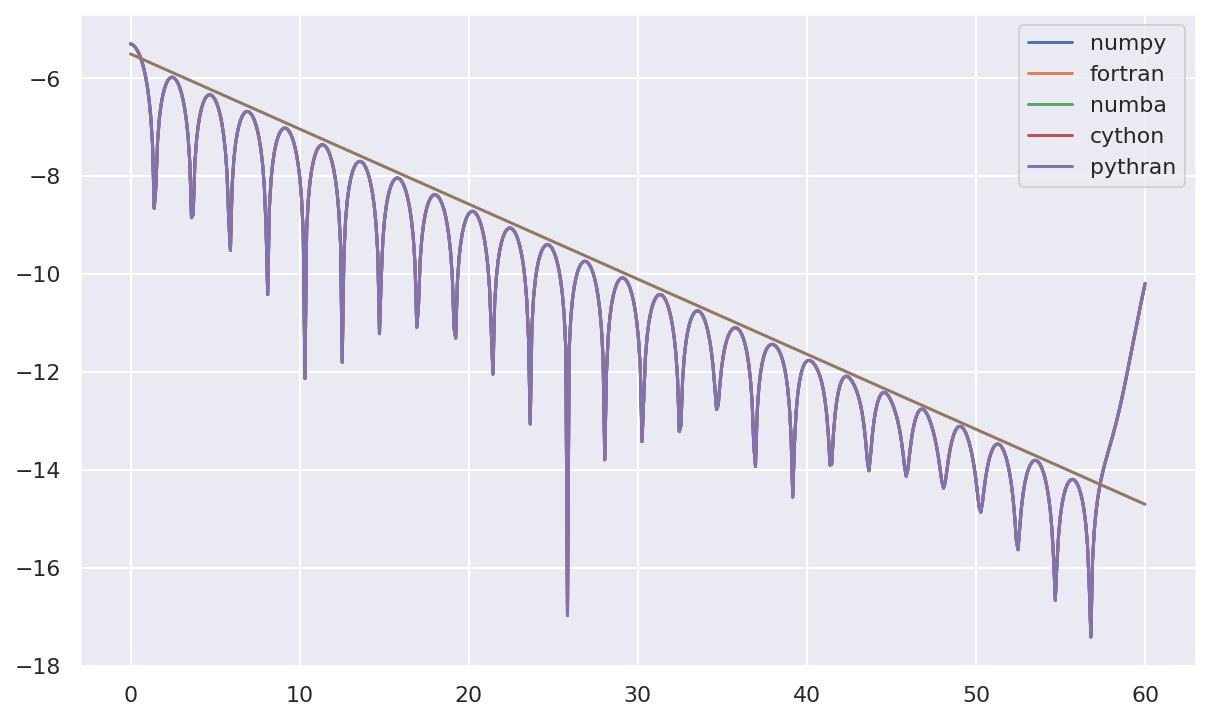

In [25]:
from time import time

elapsed_time = {}
fig, axes = plt.subplots()
for opt in ['numpy', 'fortran', 'numba', 'cython','pythran']:
    
    # Set grid
    nx, nv = 32, 64
    xmin, xmax = 0.0, 4*np.pi
    vmin, vmax = -6., 6.
    
    # Create Vlasov-Poisson simulation
    sim = VlasovPoisson(xmin, xmax, nx, vmin, vmax, nv, opt=opt)

    # Initialize distribution function
    X, V = np.meshgrid(sim.x, sim.v)
    eps, kx = 0.001, 0.5
    f = (1.0+eps*np.cos(kx*X))/np.sqrt(2.0*np.pi)* np.exp(-0.5*V*V)

    # Set time domain
    nstep = 600
    t, dt = np.linspace(0.0, 60.0, nstep, retstep=True)
    
    # Run simulation
    etime = time()
    nrj = sim.run(f, nstep, dt)
    print(" {0:12s} : {1:.4f} ".format(opt, time()-etime))
    
    # Plot energy
    axes.plot(t, nrj, label=opt)

    
axes.plot(t, -0.1533*t-5.50)
plt.legend();

## References
- [Optimizing Python with NumPy and Numba](https://jakevdp.github.io/blog/2015/02/24/optimizing-python-with-numpy-and-numba/)
